In [1]:
import pandas as pd

In [2]:
train_file_path = '../data/train.parquet'
test_file_path = '../data/test.parquet'

In [3]:
df_train = pd.read_parquet(train_file_path)
df_test = pd.read_parquet(test_file_path)

In [4]:
len(df_test), len(df_train)

(808, 3030)

In [5]:
df_test[:10]

,index,claim_id,patent_application_id,cited_document_id,text,text_b,label,date,DIznQ_0
0,5388961.0,129493_1,EP3181072A1,EP2695581,The medical device of claim 1 wherein said hou...,In one embodiment the device also includes at ...,1.0,20170621.0,0.100158
1,5709813.0,220378_0,EP3208314A1,EP2700680,Process according to any one of the preceding ...,According to another embodiment the white pigm...,0.0,20170823.0,0.360129
2,5301576.0,141174_0,EP3176737A1,EP2838044,The method of any of claims 11 to 12 further c...,In certain embodiments the method further comp...,0.0,20170607.0,0.989856
3,5907836.0,185424_1,EP3232016A1,EP2990613,A gas turbine engine 20 comprising an engine s...,Referring now to FIG.6 an axial section view o...,1.0,20171018.0,0.672025
4,5847774.0,205515_0,EP3223203A1,EP2182489,The system of claim 1 the operations comprisin...,Each of the entry and exit gates 202 204 compr...,0.0,20170927.0,0.890847
5,5689422.0,219916_0,EP3206366A1,EP2922268,The method of claim 1 or 2 further comprising ...,The task of displaying scores on an external d...,0.0,20170816.0,0.374923
6,5211570.0,145282_1,EP3166097A1,EP2892045,A display apparatus comprising a display modul...,For example the first radius of horizontal cur...,1.0,20170510.0,0.929440
7,5889240.0,175305_0,EP3229497A1,EP2325843,The equalizer device according to claim 1 wher...,A playlist is typically specified by a set of ...,0.0,20171011.0,0.434911
8,5719314.0,210852_1,EP3211524A1,EP1762825,The display device according to claim 4 furthe...,As previously described with reference to the ...,1.0,20170830.0,0.635184
9,5571536.0,125733_0,EP3193009A1,EP1650430,The method for hydrodynamic energy generation ...,Via the liquid supply 14 losses which are due ...,0.0,20170719.0,0.473889


In [6]:
df_train[:10]

,Unnamed: 0,index,claim_id,patent_application_id,cited_document_id,text,text_b,label,date,DIznQ_0
0,2617799.0,2617799.0,61865_1,EP2887198A1,EP2631759,The mobile terminal of claim 5 wherein the fir...,The input unit 350 may receive an input of var...,1.0,20150624.0,0.131968
1,3576167.0,3576167.0,146419_0,EP3001323A1,EP2141607,A method according to claim 5 further comprisi...,Although it is not shown in the figure 1 the m...,0.0,20160330.0,0.166223
2,2082491.0,2082491.0,38536_0,None,EP1593936,The method of claim 7 wherein the identifying ...,In the event that L1 is a curved segment and L...,0.0,20150107.0,0.249417
3,4856666.0,4856666.0,173866_0,EP3133831A1,EP2615853,The incar communication system claim 8 the sec...,While the system and method for processing sou...,0.0,20170222.0,0.658186
4,3973102.0,3973102.0,149117_1,EP3040810A1,EP2846330,The method of claim 1 wherein the generating t...,Further in certain embodiments the transformat...,1.0,20160706.0,0.579230
5,4786859.0,4786859.0,139563_1,EP3125508A1,EP1971111,The electronic device 10 defined in any preced...,The cover 90 is formed of a transparent materi...,1.0,20170201.0,0.471250
6,3871661.0,3871661.0,153120_1,EP3029637A1,EP2772813,The method of any preceding claim further comp...,Turning to FIG.3 a flow chart of a method 300 ...,1.0,20160608.0,0.445079
7,4941581.0,4941581.0,138586_0,EP3141982A1,EP2674834,The method of claim 9 wherein the executing of...,In accordance with another aspect of the prese...,0.0,20170315.0,0.774844
8,1724834.0,1724834.0,48102_1,EP2753011A9,EP1598960,The branching unit 210 of any previous claim w...,The optical transmission system 1 comprises te...,1.0,20140903.0,0.161361
9,3142319.0,3142319.0,100277_1,EP2945141A1,EP2302495,Nontransitory computerreadable storage medium ...,The user can select to return to the execution...,1.0,20151118.0,0.858639


In [7]:
rows_with_nulls = df_train[df_train.isnull().any(axis=1)]
rows_with_nulls

,Unnamed: 0,index,claim_id,patent_application_id,cited_document_id,text,text_b,label,date,DIznQ_0
2,2082491.0,2082491.0,38536_0,None,EP1593936,The method of claim 7 wherein the identifying ...,In the event that L1 is a curved segment and L...,0.0,20150107.0,0.249417
22,1747241.0,1747241.0,13262_0,EP2778239A1,EP2239343,A method of forming a coiled steel tube compri...,None,0.0,20140917.0,0.282161
41,4546318.0,4546318.0,134320_1,EP3104362A1,EP1939589,The method of claim 1 or 2 wherein the second ...,Further when the road link of the traveling lo...,1.0,NaN,0.349904
54,4353002.0,4353002.0,167953_1,EP3085249A1,EP2230940,A process for making a composition with an ene...,In one embodiment of the present invention the...,1.0,NaN,0.819228
81,3219573.0,3219573.0,102628_1,EP2953380A1,EP2723102,A microphone module according to claim 11 wher...,Figure 8 illustrates a hearing aid 90 wherein ...,1.0,20151209.0,NaN
...,...,...,...,...,...,...,...,...,...,...
2996,2372497.0,2372497.0,59286_0,EP2860907A1,EP2571184,A computer program comprising instruction code...,Simultaneously the spectral resources of the l...,0.0,20150415.0,NaN
3003,416116.0,416116.0,None,EP2549304A1,EP1892609,The conductive film 1 according to claim 2 whe...,The undercoat layers 13 and 23 are formed from...,1.0,20130123.0,0.161627
3013,2225497.0,2225497.0,87481_1,EP2843530A1,EP2530677,None,FIG.1 shows a timeline displayed on a touch sc...,1.0,20150304.0,0.002436
3019,2964253.0,2964253.0,91232_0,EP2926774A1,None,The reverse shoulder orthopaedic implant of cl...,According to a variant solution not shown here...,NaN,20151007.0,0.705214


In [8]:
rows_with_nulls = df_train[df_train[['text', 'text_b', 'label', 'patent_application_id', 'cited_document_id']].isnull().any(axis=1)]
rows_with_nulls

,Unnamed: 0,index,claim_id,patent_application_id,cited_document_id,text,text_b,label,date,DIznQ_0
2,2082491.0,2082491.0,38536_0,None,EP1593936,The method of claim 7 wherein the identifying ...,In the event that L1 is a curved segment and L...,0.0,20150107.0,0.249417
22,1747241.0,1747241.0,13262_0,EP2778239A1,EP2239343,A method of forming a coiled steel tube compri...,None,0.0,20140917.0,0.282161
118,3100242.0,3100242.0,99167_1,None,EP2723005,The audiodata transmitting system as claimed i...,Particularly the controller 140 may control th...,1.0,20151111.0,NaN
142,2010553.0,2010553.0,66652_1,EP2814251A1,EP2393302,None,On the other hand when the output is switched ...,1.0,20141217.0,0.980497
181,4010683.0,4010683.0,162488_1,EP3043328A1,EP2615591,The device of any one of claims 13 wherein the...,In this example the results of play are genera...,NaN,20160713.0,0.481892
...,...,...,...,...,...,...,...,...,...,...
2923,1264192.0,1264192.0,15886_1,None,EP2114058,A computerreadable medium storing computerexec...,For example assuming that call function is sel...,1.0,20140226.0,0.388855
2985,1785565.0,1785565.0,18978_1,EP2781203A1,EP2543339,None,Figures 7a and 7b schematically show a surgica...,1.0,20140924.0,0.318388
3013,2225497.0,2225497.0,87481_1,EP2843530A1,EP2530677,None,FIG.1 shows a timeline displayed on a touch sc...,1.0,20150304.0,0.002436
3019,2964253.0,2964253.0,91232_0,EP2926774A1,None,The reverse shoulder orthopaedic implant of cl...,According to a variant solution not shown here...,NaN,20151007.0,0.705214


In [9]:
rows_with_nulls_test = df_test[df_test[['text', 'text_b', 'label', 'patent_application_id', 'cited_document_id']].isnull().any(axis=1)]
len(rows_with_nulls_test)

41

In [10]:
combined_df = pd.concat([df_train, df_test])
len(combined_df)

3838

In [11]:
df_combined_filtered = combined_df[combined_df[['text', 'text_b', 'label']].notnull().all(axis=1)]
len(df_combined_filtered)

3722

In [12]:
df_combined_filtered.columns

Index(['Unnamed: 0', 'index', 'claim_id', 'patent_application_id',
       'cited_document_id', 'text', 'text_b', 'label', 'date', 'DIznQ_0'],
      dtype='object')

In [13]:
df_renamed = df_combined_filtered.rename(columns={'Unnamed: 0': 'index0', 'index': 'index1', 'patent_application_id': 'citing_docref', 'cited_document_id': 'cited_docref'})


In [14]:
df_renamed.head()

,index0,index1,claim_id,citing_docref,cited_docref,text,text_b,label,date,DIznQ_0
0,2617799.0,2617799.0,61865_1,EP2887198A1,EP2631759,The mobile terminal of claim 5 wherein the fir...,The input unit 350 may receive an input of var...,1.0,20150624.0,0.131968
1,3576167.0,3576167.0,146419_0,EP3001323A1,EP2141607,A method according to claim 5 further comprisi...,Although it is not shown in the figure 1 the m...,0.0,20160330.0,0.166223
2,2082491.0,2082491.0,38536_0,None,EP1593936,The method of claim 7 wherein the identifying ...,In the event that L1 is a curved segment and L...,0.0,20150107.0,0.249417
3,4856666.0,4856666.0,173866_0,EP3133831A1,EP2615853,The incar communication system claim 8 the sec...,While the system and method for processing sou...,0.0,20170222.0,0.658186
4,3973102.0,3973102.0,149117_1,EP3040810A1,EP2846330,The method of claim 1 wherein the generating t...,Further in certain embodiments the transformat...,1.0,20160706.0,0.579230


In [15]:
filtered_df = df_renamed[df_renamed['index0'] == 3657893.0]
filtered_df

,index0,index1,claim_id,citing_docref,cited_docref,text,text_b,label,date,DIznQ_0
93,3657893.0,3657893.0,167973_0,EP3010210A1,EP1729245,The card slot structure as claimed in claim 3 ...,A card locking unit 24 for locking the card 25...,0.0,20160420.0,0.934443
1576,3657893.0,3657893.0,167973_0,EP3010210A1,EP1729245,The card slot structure as claimed in claim 3 ...,A card locking unit 24 for locking the card 25...,0.0,20160420.0,0.934443


In [ ]:
df_renamed[90:120]

In [17]:
duplicates = df_renamed.duplicated(subset=['index0', 'index1', 'citing_docref', 'cited_docref'], keep=False)

cleaned_df = df_renamed[~duplicates]
len(cleaned_df), len(duplicates), len(df_renamed)

(3650, 3722, 3722)

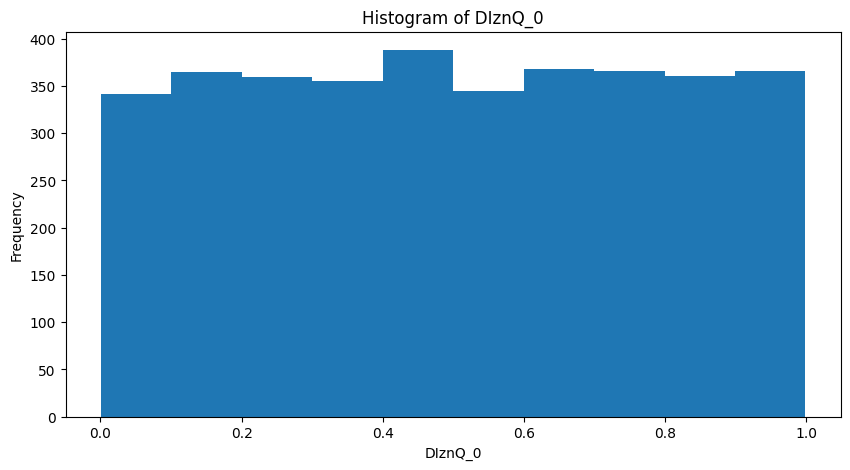

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.hist(cleaned_df['DIznQ_0'], bins=10)
plt.title('Histogram of DIznQ_0')
plt.xlabel('DIznQ_0')
plt.ylabel('Frequency')
plt.show()

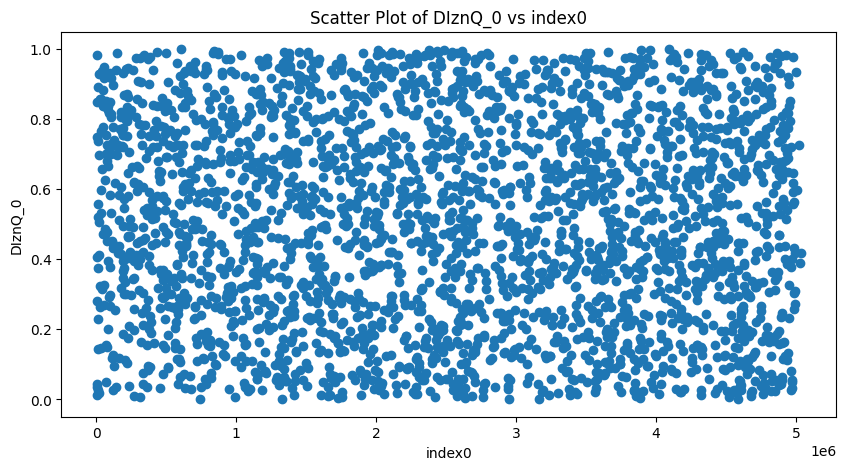

In [19]:
plt.figure(figsize=(10, 5))
plt.scatter(cleaned_df['index0'], cleaned_df['DIznQ_0'])
plt.title('Scatter Plot of DIznQ_0 vs index0')
plt.xlabel('index0')
plt.ylabel('DIznQ_0')
plt.show()

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
import torch

In [22]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [23]:

if device.type == 'cpu':
    small_sample = 0.005
    new_length = int(small_sample * len(cleaned_df))
    df = cleaned_df.sample(n=new_length, random_state=42).reset_index(drop=True)
else:
    df = cleaned_df.sample(frac=1, random_state=42).reset_index(drop=True)


train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


train_df = train_df[['text', 'text_b', 'label']]
test_df = test_df[['text', 'text_b', 'label']]


In [24]:
test_df.head()

,text,text_b,label
0,The lithium secondary battery of any of claims...,Subsequently the battery can 5 is caulked thro...,0.0
1,A system comprising a wireless communications ...,Fig.3a illustrates a flow diagram of a communi...,1.0
8,The load coupling device 22 according to claim...,In the embodiments of both Figs 24 and Fig.5 a...,0.0
5,Elasticized structure 1 according to any one o...,It is understood that the first piece can be m...,1.0


In [25]:
len(test_df), len(train_df)

(4, 14)

In [26]:
train_label_counts = train_df['label'].value_counts()
test_label_counts = test_df['label'].value_counts()
train_label_counts

label
1.0    8
0.0    6
Name: count, dtype: int64

In [27]:
test_label_counts

label
0.0    2
1.0    2
Name: count, dtype: int64

In [28]:
def save_to_jsonl(df, filename):
    df.to_json(filename, orient='records', lines=True)

save_to_jsonl(train_df, '../data/train_0.05%.jsonl')
save_to_jsonl(test_df, '../data/test_0.05%.jsonl')

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [4]:
encoded = tokenizer("Hello, my dog is cute", "Hello, my cat is amazing", return_tensors="pt")

decoded = tokenizer.decode(encoded["input_ids"][0])
print(decoded)

<s>Hello, my dog is cute</s></s>Hello, my cat is amazing</s>


In [5]:
def preprocess_function(batch):
    return tokenizer(batch["text"], batch["text_b"], truncation=True, padding="max_length")

In [6]:
import datasets

In [7]:
dataset = datasets.load_dataset("json", data_files={"train": "../data/train_0.05%.jsonl", "test": "../data/test_0.05%.jsonl"})
tokenized_data = dataset.map(preprocess_function, batched=True)
print(tokenized_data)

Map: 100%|██████████| 14/14 [00:00<00:00, 500.56 examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'text_b', 'label', 'input_ids', 'attention_mask'],
        num_rows: 14
    })
    test: Dataset({
        features: ['text', 'text_b', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4
    })
})


In [ ]:
tokenized_data['train'][0]

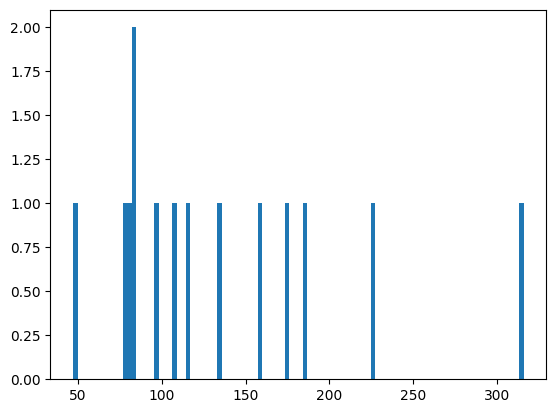

In [8]:
doc1_and_doc2 = []

for item in dataset["train"]:
    doc1_and_doc2.append(item["text"] + "\n" + item["text_b"])

# Visualize the distribution of the length of the 2 documents combined together
import matplotlib.pyplot as plt
plt.hist([len(item.split()) for item in doc1_and_doc2], bins=100)
plt.show()

In [9]:
import numpy as np

In [17]:
def compute_metrics(eval_pred):
    print(eval_pred)
    f1_score = datasets.load_metric("f1")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1_score.add_batch(predictions=predictions, references=labels.cpu().tolist())
    return f1_score.compute()

In [11]:
from transformers import Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
%store dataset df_test df_train model tokenized_data

Stored 'dataset' (DatasetDict)
Stored 'df_test' (DataFrame)
Stored 'df_train' (DataFrame)
Stored 'model' (RobertaForSequenceClassification)
Stored 'tokenized_data' (DatasetDict)


c:\Users\alena\MyFolder\DIL\PatentMatchBaselineAlena\venv\Lib\site-packages\IPython\extensions\storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/dataset requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj
c:\Users\alena\MyFolder\DIL\PatentMatchBaselineAlena\venv\Lib\site-packages\IPython\extensions\storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/df_test requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj
c:\Users\alena\MyFolder\DIL\PatentMatchBaselineAlena\venv\Lib\site-packages\IPython\extensions\storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/df_train requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj
c:\Users\alena\MyFolder\DIL\PatentMatchBaselineAlena\venv\Lib\site-packages\IPython\extensions\storemagic.py:229: UserWarning: This is 

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",          # output directory
    num_train_epochs=3,              # total # of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=tokenized_data["train"],         # training dataset
    eval_dataset=tokenized_data["test"],           # evaluation dataset
    compute_metrics=compute_metrics,      # the callback that computes metrics of interest
)

trainer.train()

trainer.evaluate()